<a href="https://colab.research.google.com/github/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/blob/main/Ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz

     |████████████████████████████████| 1.5MB 11.5MB/s 
     |████████████████████████████████| 737kB 41.2MB/s 
     |████████████████████████████████| 4.7MB 39.7MB/s 
     |████████████████████████████████| 296kB 40.1MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [2]:
!pip install pymc3==3.8

     |████████████████████████████████| 911kB 9.7MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [15]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [5]:
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/Howell1.csv'
d = pd.read_csv(url, sep=';')
d2 = d[d.age > 18]
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))
d2.head()

,height,weight,age,male,weight_c
0,151.765,47.825606,63.0,1,2.780064
1,139.700,36.485807,63.0,0,-8.559736
2,136.525,31.864838,65.0,0,-13.180705
3,156.845,53.041915,41.0,1,7.996372
4,145.415,41.276872,51.0,0,-3.768671


In [6]:
# 4.42
with pm.Model() as m_4_4_2:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta = pm.Normal('beta', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1113.53it/s]


In [8]:
with m_4_4_2:
    summary = pm.summary(
        trace_4_4_2,
        var_names=["alpha", "beta", "sigma"],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.649,0.276,154.103,155.132,0.005,0.004,2551.0,2551.0,2541.0,1571.0,1.0
beta,0.905,0.043,0.831,0.987,0.001,0.001,2754.0,2754.0,2758.0,1354.0,1.0
sigma,5.140,0.197,4.785,5.521,0.004,0.003,2599.0,2599.0,2596.0,1295.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


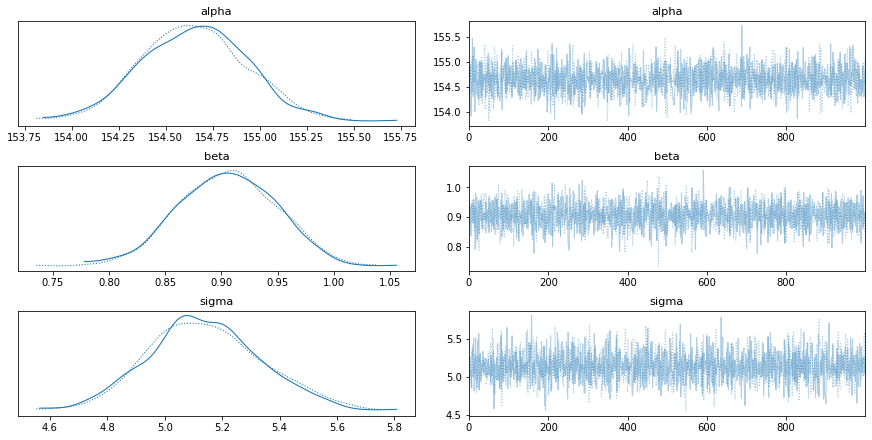

In [9]:
_ = pm.traceplot(trace_4_4_2, var_names=["alpha", "beta", "sigma"])

In [11]:
pm.trace_to_dataframe(trace_4_4_2)[:5]

,alpha,beta,sigma
0,154.115683,0.979712,4.969688
1,154.363866,0.885428,4.931993
2,154.892109,0.868062,5.184464
3,154.383441,0.936444,5.027310
4,154.923550,0.908499,5.263249


Text(0, 0.5, 'height')

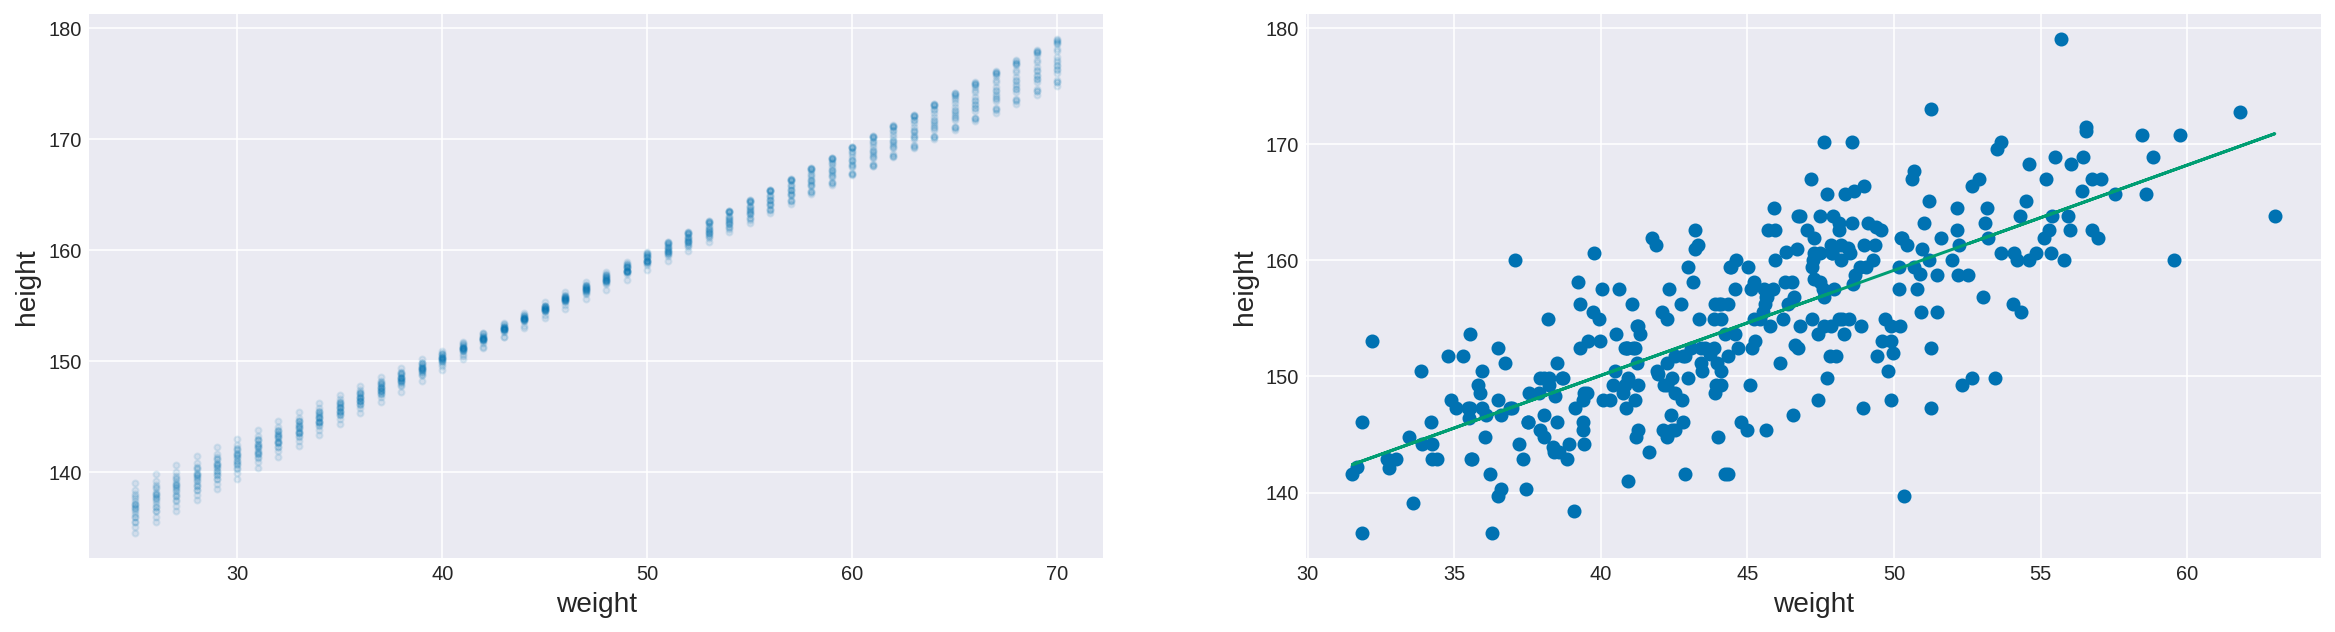

In [56]:
# 4.58
# We are doing manually, what in thebook is done using the link function. 
# In the book on code 4.58 the following operations are performed manually.
weigth_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = trace_4_4_2[::100]
mu_pred = np.zeros((len(weigth_seq), len(chain_N_thinned)*trace_4_4_2.nchains))

for i, w in enumerate(weigth_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * (w - d2.weight.mean())

# plot the sample mu
_, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(weigth_seq, mu_pred, 'C0.', alpha=0.1)
ax[0].set_xlabel('weight', fontsize=14)
ax[0].set_ylabel('height', fontsize=14)

# plot raw data and mean 
ax[1].plot(d2.weight, d2.height, 'o')
ax[1].plot(d2.weight, trace_4_4_2['alpha'].mean() + trace_4_4_2['beta'].mean() * d2.weight_c)
ax[1].set_xlabel('weight', fontsize=14)
ax[1].set_ylabel('height', fontsize=14)

In [57]:
# Now we are going to use sample_ppc() from PyCM3. 
# This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. 
# Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)
height_pred = pm.sample_ppc(trace_4_4_2, 200, m_4_4_2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 740.10it/s]


In [58]:
height_pred_hpd = pm.hpd(height_pred['height'])
mu_hpd = pm.hpd(mu_pred.T, 0.89)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


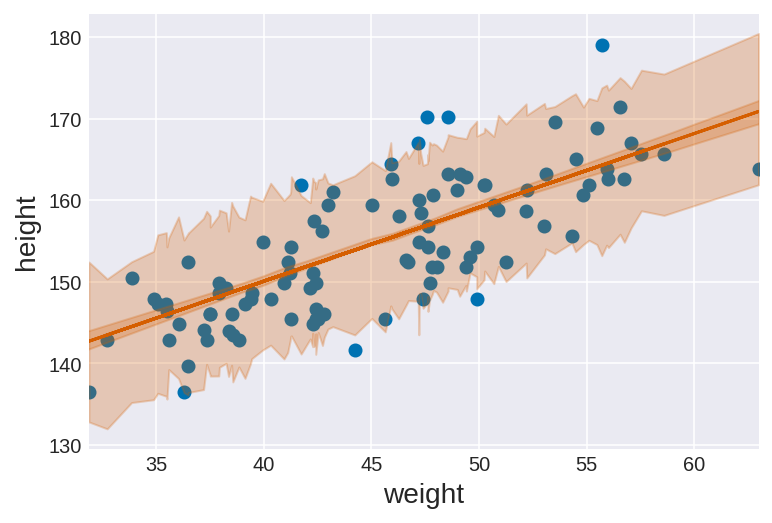

In [63]:
N = 100
idx = np.argsort(d2.weight.values[:N])
d2_weight_ord = d2.weight.values[:N][idx]
height_pred_hpd_ord = height_pred_hpd[idx]

# The solid line is the average line for mean height
# The narrow shadow is the distribution of 89% interval of mu
# The wider shaded region is the 89% interval of the actual height at each weight

plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(d2.weight[:N], trace_4_4_2['alpha'].mean() + trace_4_4_2['beta'].mean() * d2.weight_c[:N], color='C2')
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(d2_weight_ord, height_pred_hpd_ord[:,0], height_pred_hpd_ord[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());